## モジュールのインポートなど

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6
from sklearn.datasets import make_classification
import random


In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)

    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    # initialise and raise input errors
    def __init__(self, n_arms):
        if not type(n_arms)==int:
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms

    @abstractmethod
    # raise input errors
    def play(self, context):
        """Play a round

        Parameters
        ----------
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.

        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set
            {0, ..., n_arms - 1}.
        """
        if not type(context) == np.ndarray:
            raise TypeError("`context` must be numpy.ndarray")
        if not context.shape == (n_arms, n_dims):
            raise TypeError("`context` must have shape (n_arms, n_dims)")
        self.context = context


    @abstractmethod
    # raise input errors
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play

        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.

        reward : float
            Reward received from the arm.

        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The
            0-th axis indexes the arms, and the 1-st axis indexes the
            features. Non-contextual bandits accept a context of None.
        """
        if not (type(arm) == int or arm.dtype == 'int32'):  # 元は64だが，データが32で読み込まれているので，32にしてある
            raise TypeError("`arm` must be int type")
        if not (arm >= 0 and arm <= (n_arms-1)):
            raise ValueError("`arm` must be the the set {0, .., n_arms - 1}")
        if not (type(reward) == float or reward.dtype == 'float64'):
            raise TypeError("`reward` must be float type")
        if not (context.shape == (n_arms, n_dims) and context.dtype == 'float64') :
            raise TypeError("`context` must be float numpy in shape (n_events, n_arms, n_dims)")
        # get the values
        self.arm = arm
        self.reward = reward
        self.context = context



In [3]:
# Define global functions
# 推定最適行動が複数ある場合，その中からランダムで行動を選ぶグローバル関数．
def break_tie(_range):
    indices = np.argwhere(_range == np.max(_range))
    index = np.random.randint(0,len(indices))

    return indices[index][0]


## 決定木ベースの人工データ(3次元3行動，全て決定木推論に使用)を生成

In [47]:
# 人工データを生成したい
df = pd.DataFrame()
length = 10000
n_arms = 3
n_dims = 3

# BanditForestにおける人工データ生成方法は以下の通り
# df["Gender"] = np.random.choice([1, 0], length, p=[0.5, 0.5])
# df["AgeGroup"] = np.random.choice([0,1,2,3,4,5,6,'NA'], length, p = [.08,.12,.18,.22,.18,.12,.08,.02])
# df["Program"] = np.random.choice(["A","B","C","D","E","NA"], length, p = [.2,.03,.17,.25,.30,.05])
# df["Income"] = np.random.randint(50000, 500000, length)
# df["State"] = np.random.choice(["NJ","NY","CA","TX","NA"], length, p = [.2,.3,.35,.10,.05])
# df["Device"] = np.random.choice(["Mobile","Desktop","Tablet"], length, p = [.6,.35,.05])
# df["OS"] = np.random.choice(["Apple","Windows"], length, p = [.5,.5])
# df["Browser"] = np.random.choice(["Opera","Chrome","Safari"], length, p = [.1,.6,.3])

df["action"] = np.random.randint(0, n_arms, size=length)
df["Gender"] = np.random.choice([1, 0], length, p=[0.5, 0.5])
df["AgeGroup"] = np.random.choice([0,1,2,3,4,5,6,7], length, p = [.08,.12,.18,.22,.18,.12,.08,.02])
df["Program"] = np.random.choice([0,1,2,3,4,5], length, p = [.2,.03,.17,.25,.30,.05])
# df["Income"] = np.random.randint(0, 10, size=length)
# df["State"] = np.random.choice([0,1,2,3,4], length, p = [.2,.3,.35,.10,.05])
# df["Device"] = np.random.choice([0,1,2], length, p = [.6,.35,.05])
# df["OS"] = np.random.choice([0,1], length, p = [.5,.5])
# df["Browser"] = np.random.choice([0,1,2], length, p = [.1,.6,.3])
# df["dummy_one"] = np.random.choice([0,1,2,3,4], length, p = [.2,.3,.05,.40,.05])
# df["dummy_two"] = np.random.choice([0,1,2], length, p = [.2,.55,.25])


In [48]:
df.head(10)


,action,Gender,AgeGroup,Program
0,0,1,6,4
1,2,1,2,3
2,0,0,3,3
3,0,1,1,4
4,0,0,3,3
5,1,1,3,2
6,0,0,5,0
7,0,0,6,3
8,0,1,1,2
9,1,1,6,3


In [49]:
# 必ず上のセルから順番に動かす

# 写真の決定木を用いて報酬設定
reward_set = np.empty(shape=(0,))
# 行動ごとに閾値だけ変えてやってみる(面倒くさいので木の構造は変えていない)
# 極端な分割は避けたい（ただ報酬変えれば大丈夫では？）
threshold = [[0,0,1],
             [2,4,2],
             [2,3,3]]  # threshold[閾値idx][行動idx]で利用

reward_list = [[[.25,.75], [.90,.10], [.90,.10]],
               [[.90,.10], [.25,.75], [.90,.10]],
               [[.90,.10], [.90,.10], [.25,.75]]]

hyper_domain_count_list = [0] * 9  # 人工データの偏りを測るリスト1

for row in df.itertuples():
    # 報酬の値を高くしすぎた気がするので，紙に書いたよりも低い値に変更(平均0.25くらいになるように，，，)
    tmp_a = row[1]

    # 現在木は1本だけど，ブートストラップが不利になりそう ← 探索の複雑性が減少
    # 行動ごとに複数本もあり得るが，今はスルー
    if row[2] == threshold[0][tmp_a]:
        if row[3] <= threshold[1][tmp_a]:
            reward_set =np.append(reward_set, np.random.choice([0,1], p = [.90,.10]))
            hyper_domain_count_list[0] += 1
        else:
            reward_set =np.append(reward_set, np.random.choice([0,1], p = [.25,.75]))  # 当たり
            hyper_domain_count_list[1] += 1
    else:
        if row[4] <= threshold[2][tmp_a]:
            reward_set =np.append(reward_set, np.random.choice([0,1], p = [.95,.05]))
            hyper_domain_count_list[2] += 1
        else:
            reward_set =np.append(reward_set, np.random.choice([0,1], p = [.85,.15]))
            hyper_domain_count_list[3] += 1

    # 報酬の分布が簡単すぎる可能性
    # 似たような分布を複数の葉ノードに設置してやって，試行回数重ねないといけないようにする
    # 木の深さを調整出来るように関数組めたら〇

    # ノードごと報酬の事後分布の被りがあるかどうか確認
    # →β分布のα,β推定→pのヒストグラムを作る
    # ノードごとにヒストグラムを見て分布に被っている所があるように調整する．

print(hyper_domain_count_list)
df["reward"] = reward_set
df = df[["action", "reward", "Gender", "AgeGroup", "Program"]]
df.head(20)


[2629, 2396, 2750, 2225, 0, 0, 0, 0, 0]


,action,reward,Gender,AgeGroup,Program
0,0,0.0,1,6,4
1,2,0.0,1,2,3
2,0,1.0,0,3,3
3,0,0.0,1,1,4
4,0,0.0,0,3,3
5,1,0.0,1,3,2
6,0,1.0,0,5,0
7,0,0.0,0,6,3
8,0,0.0,1,1,2
9,1,0.0,1,6,3


In [50]:
# typeがfloatぽかったので，intに修正
df['reward'] = df['reward'].apply(lambda x: int(x))
df.head(20)


,action,reward,Gender,AgeGroup,Program
0,0,0,1,6,4
1,2,0,1,2,3
2,0,1,0,3,3
3,0,0,1,1,4
4,0,0,0,3,3
5,1,0,1,3,2
6,0,1,0,5,0
7,0,0,0,6,3
8,0,0,1,1,2
9,1,0,1,6,3


In [51]:
# df["action"].to_numpy()
context = df.iloc[:, -n_dims:]
contexts = df.iloc[:, -n_dims:]

for i in range(n_arms-1):
    contexts = pd.concat([contexts, context], axis=1)

contexts = contexts.to_numpy()
print(contexts[0])


[1 6 4 1 6 4 1 6 4]


In [64]:
for i in range(7):
    tmp = df[df['action'].isin([i])][["action", "reward"]]
    print(tmp.describe())


       action       reward
count  3379.0  3379.000000
mean      0.0     0.300089
std       0.0     0.458364
min       0.0     0.000000
25%       0.0     0.000000
50%       0.0     0.000000
75%       0.0     1.000000
max       0.0     1.000000
       action       reward
count  3325.0  3325.000000
mean      1.0     0.160902
std       0.0     0.367496
min       1.0     0.000000
25%       1.0     0.000000
50%       1.0     0.000000
75%       1.0     0.000000
max       1.0     1.000000
       action       reward
count  3296.0  3296.000000
mean      2.0     0.298544
std       0.0     0.457689
min       2.0     0.000000
25%       2.0     0.000000
50%       2.0     0.000000
75%       2.0     1.000000
max       2.0     1.000000
       action  reward
count     0.0     0.0
mean      NaN     NaN
std       NaN     NaN
min       NaN     NaN
25%       NaN     NaN
50%       NaN     NaN
75%       NaN     NaN
max       NaN     NaN
       action  reward
count     0.0     0.0
mean      NaN     NaN
std    

In [52]:
# データ読み込み
arms, rewards = df["action"].to_numpy(), df["reward"].to_numpy()
arms = arms.astype(int)
rewards = rewards.astype(float)
contexts = contexts.astype(float)
n_arms = len(np.unique(arms))
n_events = len(contexts)  # ラウンド数：10000
n_dims = int(len(contexts[0])/n_arms)  # 100次元/10種の行動 = 10次元？ -> 行動ごとに10次元ずつ文脈変数が与えられている -> 見た所それぞれ違う実現値が入っているが，これはふさわしいのか？
contexts = contexts.reshape(n_events, n_arms, n_dims)

display(n_arms)
display(contexts)
print(n_dims)


3

array([[[1., 6., 4.],
        [1., 6., 4.],
        [1., 6., 4.]],

       [[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]],

       [[0., 3., 3.],
        [0., 3., 3.],
        [0., 3., 3.]],

       ...,

       [[0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.]],

       [[0., 4., 0.],
        [0., 4., 0.],
        [0., 4., 0.]],

       [[0., 3., 0.],
        [0., 3., 0.],
        [0., 3., 0.]]])

3


## Off-policy evaluation

In [10]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit

    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.

    arms : integer numpy.ndarray, shape (n_events,)
        Array containing the history of pulled arms, represented as integer
        indices in the set {0, ..., mab.n_arms}

    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.

    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms.
        The 0-th axis indexes the events in the history, the 1-st axis
        indexes the arms and the 2-nd axis indexed the features.

    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None,
        continue evaluating until the historical events are exhausted.

    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # initialise values and raise input errors
    if not (arms.shape == (n_events,) and arms.dtype == 'int32')  :  # int32でデータが読み込まれてたので，条件をint64ではなくint32にした．
        print(arms.shape)
        print(n_events)
        print(arms.dtype)
        raise TypeError("`arms` must be integer numpy in shape (n_events,)")
    if not rewards.shape == (n_events,) and rewards.dtype == 'float64' :
        raise TypeError("`rewards` must be float numpy in shape (n_events,)")
    if not contexts.shape == (n_events,n_arms, n_dims) and rewards.dtype == 'float64' :
        raise TypeError("`contexts` must be float numpy in shape (n_events, n_arms, n_dims)")
    if n_rounds == None:        # set n_rounds to infinite number to run until all data exhausted
        n_rounds = np.inf
    elif not type(n_rounds) == int:
        raise TypeError("`n_rounds` must be integer or default 'None'")

    n_round = 0     # データの行動=方策の行動となり，評価を行うことのできた回数(≠n_rounds: 設定する試行回数)
    R = []          # save the total payoff
    H = []          # save used historical events

    for i in range(n_events):
        if n_round == n_rounds:
            break
        arm = mab.play(contexts[i])
        if arm == arms[i]:                 # if historical data equals to chosen arm
            R.append(rewards[i])           # append the new rewards
            H.append([arms[i], rewards[i], contexts[i]])      # append the used events
            mab.update(arms[i], rewards[i], contexts[i])      # update the information
            n_round += 1

    # return rewards per play
    out = np.array(R)

    return out


In [11]:
# 詳細を見るために改造
def offlineEvaluate_forPrint(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit

    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.

    arms : integer numpy.ndarray, shape (n_events,)
        Array containing the history of pulled arms, represented as integer
        indices in the set {0, ..., mab.n_arms}

    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.

    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms.
        The 0-th axis indexes the events in the history, the 1-st axis
        indexes the arms and the 2-nd axis indexed the features.

    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None,
        continue evaluating until the historical events are exhausted.

    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # initialise values and raise input errors
    if not (arms.shape == (n_events,) and arms.dtype == 'int32')  :  # int32でデータが読み込まれてたので，条件をint64ではなくint32にした．
        print(arms.shape)
        print(n_events)
        print(arms.dtype)
        raise TypeError("`arms` must be integer numpy in shape (n_events,)")
    if not rewards.shape == (n_events,) and rewards.dtype == 'float64' :
        raise TypeError("`rewards` must be float numpy in shape (n_events,)")
    if not contexts.shape == (n_events,n_arms, n_dims) and rewards.dtype == 'float64' :
        raise TypeError("`contexts` must be float numpy in shape (n_events, n_arms, n_dims)")
    if n_rounds == None:        # set n_rounds to infinite number to run until all data exhausted
        n_rounds = np.inf
    elif not type(n_rounds) == int:
        raise TypeError("`n_rounds` must be integer or default 'None'")

    n_round = 0     # データの行動=方策の行動となり，評価を行うことのできた回数(≠n_rounds: 設定する試行回数)
    R = []          # save the total payoff
    H = []          # save used historical events

    for i in range(n_events):
        if n_round == n_rounds:
            break
        arm = mab.play(contexts[i], n_round)
        if arm == arms[i]:                 # if historical data equals to chosen arm
            R.append(rewards[i])           # append the new rewards
            H.append([arms[i], rewards[i], contexts[i]])      # append the used events
            mab.update(arms[i], rewards[i], contexts[i])      # update the information
            n_round += 1

    # return rewards per play
    out = np.array(R)

    return out


## 結果記録のための関数

In [27]:
def repeat_n_times(mab, is_print, arms, rewards, contexts, n):
    perform_list = []
    if is_print:
        for i in range(n):
            tmp_result = offlineEvaluate_forPrint(mab, arms, rewards, contexts, 1000)
            perform_list.append(np.mean(tmp_result))
            print(i)

        return perform_list, sum(perform_list) / n

    else:
        for i in range(n):
            tmp_result = offlineEvaluate(mab, arms, rewards, contexts, 1000)
            perform_list.append(np.mean(tmp_result))
            print(i)

        return perform_list, sum(perform_list) / n


## 1. ε-greedy MAB

In [53]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        if not (epsilon >= 0 and epsilon <= 1):
            raise ValueError("`epsilon` must be a number in [0,1]")
        if not type(epsilon) == float:
            raise TypeError("`epsilon` must be float")
        if not type(Q0) == float:
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")

        self.epsilon = epsilon
        self.q = np.full(n_arms, Q0)      # initialise q values
        self.rewards = np.zeros(n_arms)     # keep the total rewards per arm
        self.clicks = np.zeros(n_arms)      # count the pulled rounds per arm

    # select a random arm to explore or a arm with best rewards to exploit, then return the arm
    def play(self, context=None):
        super().play(context)
        if np.random.random_sample() <= self.epsilon:           #explore
            arm = np.random.randint(0,self.n_arms)
        else:
            arm = break_tie(self.q)
        return arm

    # update values
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm] / self.clicks[arm]


In [54]:
mab = EpsGreedy(3, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))


EpsGreedy average reward 0.263


In [29]:
# 10回繰り返し，最後にその平均値を算出する
# mab = EpsGreedy(3, 0.05)
perf_list, average_perf = repeat_n_times(mab, False, arms, rewards, contexts, 10)
print(perf_list)
print(average_perf)

# [0.337, 0.332, 0.329, 0.332, 0.333, 0.329, 0.33, 0.333, 0.334, 0.335]
# 0.33240000000000003


0
1
2
3
4
5
6
7
8
9
[0.337, 0.332, 0.329, 0.332, 0.333, 0.329, 0.33, 0.333, 0.334, 0.335]
0.33240000000000003


## 2. UCB MAB

In [55]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        if not rho > 0:
            raise ValueError("`rho` must be positive")
        if not (type(rho) == float and np.isreal(rho)):
            raise TypeError("`rho` must be real float")
        if not type(Q0) == float :
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")

        self.rho = rho
        self.q = np.full(n_arms, Q0)
        self.rewards = np.zeros(n_arms)
        self.avg_rewards = np.zeros(n_arms)
        self.clicks = np.zeros(n_arms)
        self.round = 0        # to count the number of round played

    def play(self, context=None):
        super().play(context)
        self.round += 1
        self.q = np.where(self.clicks != 0, self.avg_rewards + np.sqrt(self.rho * np.log10(self.round) / self.clicks), self.q)

        arm = break_tie(self.q)

        return int(arm)

    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += reward
        self.avg_rewards[arm] = self.rewards[arm]/ self.clicks[arm]


In [56]:
# warning control
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [57]:
mab = UCB(3, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('UCB average reward', np.mean(results_UCB))


UCB average reward 0.294


In [33]:
perf_list, average_perf = repeat_n_times(mab, False, arms, rewards, contexts, 10)
print(perf_list)
print(average_perf)

# [0.321, 0.33, 0.333, 0.329, 0.335, 0.332, 0.33, 0.333, 0.335, 0.334]
# 0.33120000000000005


0
1
2
3
4
5
6
7
8
9
[0.321, 0.33, 0.333, 0.329, 0.335, 0.332, 0.33, 0.333, 0.335, 0.334]
0.33120000000000005


## 3. LinUCB contextual MAB

In [34]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, alpha):
        if not (type(n_dims) == int or n_dims.dtype == 'int64'):
            raise TypeError("`n_dims` must be integer type")
        if not (type(alpha) == float or alpha.dtype == 'float64'):
            raise TypeError("`alpha` must be float")
        if not (alpha > 0.0 and np.isreal(alpha)):
            raise ValueError("`alpha` must be positive real")

        super().__init__(n_arms)
        self.n_dims = n_dims
        self.alpha = alpha
        self.post_dist = np.zeros(n_dims)
        '''initialise keys and values; key is arm, A for covariance, inv_A for inverse of A,
                                        b for reward, theta for coefficient vector'''
        self.A = np.array(np.identity(n_dims))
        self.inv_A = [np.linalg.inv(self.A)]*10
        self.A  = [self.A]*10

        self.b = [np.zeros(n_dims)]*10
        self.theta = [(np.linalg.inv(np.identity(n_dims)) @  np.zeros(n_dims))]*10

    # return the best arm
    def play(self, context):
        super().play(context)
        # calculate posterior distribution of the coefficient vector
        for arm in range(self.n_arms):
            inv_A = self.inv_A[arm]
            theta = self.theta[arm]

            # calculate posterior distribution of the coefficient vector
            tmp_1 = self.post_dist[arm]
            tmp_2 = context[arm]
            self.post_dist[arm] = theta @ context[arm] + self.alpha * np.sqrt(context[arm].T @ inv_A @ context[arm])

        arm = break_tie(self.post_dist)
        return int(arm)

    # update dictionary
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        reshaped_context = context[arm].reshape(-1,1)   # reshape to the right form
        self.A[arm] = self.A[arm] + reshaped_context @ reshaped_context.T
        self.inv_A[arm] = np.linalg.inv(self.A[arm])
        self.b[arm] = self.b[arm] + reward * context[arm]
        self.theta[arm] = self.inv_A[arm] @ self.b[arm]




In [58]:
mab = LinUCB(3, 3, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('LinUCB average reward', np.mean(results_LinUCB))


LinUCB average reward 0.496


In [36]:
perf_list, average_perf = repeat_n_times(mab, False, arms, rewards, contexts, 10)
print(perf_list)
print(average_perf)

# [0.513, 0.511, 0.509, 0.516, 0.518, 0.517, 0.517, 0.517, 0.52, 0.521]
# 0.5159


0
1
2
3
4
5
6
7
8
9
[0.513, 0.511, 0.509, 0.516, 0.518, 0.517, 0.517, 0.517, 0.52, 0.521]
0.5159


## 4. TreeBootstrap contextual MAB

In [37]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int (default: 10)
        Number of arms.

    n_dims : int (default: 10)
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward.
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier(max_depth=2)):
        # 決定木はsklearnのDecisionTreeClassifier使用(CART分類木)
        # てっきり回帰木かと思ったが，これの.predict_proba()を利用して推定値を出力しているみたい

        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[[] for i in range(10) ] for j in range(1) ]  # 行動が10種類あるので，10枠． -> 行動の種類によって柔軟に変えられるようにした方がいいかも
        self.r = [[0 for i in range(10) ] for j in range(1) ]  # 最終的には[[0. ] [1. ] [1. ] [1. ] [0. ] [... [1. ]]のような形になってそう
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        self.stopper = 0

        self.features = []
        self.thresholds = []
        self.values = []
        self.preds = []
        # feature = tree.feature
        # threshold = tree.threshold
        # value = tree.value  # 各クラスのデータ数


    # return the best arm
    def play(self, context):
        super().play(context)  # 型確認，文脈観測

        def vstack_for_bootstrap(older, newer):
            if len(older) == 0:
                return newer
            else:
                return np.vstack((older, newer))

        # 全ての行動について以下forループ
        for kaisuu, arm in enumerate(range(self.n_arms)):
            shaped_context = context[arm].reshape(1, -1)         # 各行動に対応する文脈情報を取り出す

            # とりあえず各行動1回は実行してデータ(文脈, 報酬)を回収する
            if len(self.D[0][arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1
            else:
                # インデックス0を取ってくるだけで許されるのか？
                # 普通に許されなさそう．
                sample_context = self.D[0][arm]
                sample_reward = self.r[0][arm]

                # Bootstrapping
                # 「成功」と「失敗」が1つずつ存在しなければいけないので，最初の2回は先頭から2つを取る．残りは全体から選ぶ．
                b_context = np.vstack((sample_context[0], sample_context[1]))
                b_reward = np.vstack((sample_reward[0], sample_reward[1]))

                for i in range(len(sample_context)):
                    if i >= 2:
                        sampling_number = random.randint(0, len(sample_context)-1)
                        b_context = vstack_for_bootstrap(b_context, sample_context[sampling_number])
                        b_reward = vstack_for_bootstrap(b_reward, sample_reward[sampling_number])
                # Bootstrapping終了

                # tree = self.tree.fit(sample_context, sample_reward)
                tree = self.tree.fit(b_context, b_reward)          # train the tree classifier -> sample_からb_に変更
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context
                # print(temp_p)

                # print("Children(Left): ", tree.tree_.children_left)
                # print("Children(Right): ", tree.tree_.children_right)
                # print("feature: ", tree.tree_.feature)
                # print("threshold: ", tree.tree_.threshold)
                # print("value: ", tree.tree_.value)
                # print("proba: ", temp_p)
                # print("context: ", shaped_context)
                # print("leaf_idx_fallen: ", tree.apply(shaped_context), "\n")

                self.prob[arm] = temp_p[0][1]

        arm = break_tie(self.prob)  # [0.1, 0.01, 0.8, ...]行動ごと推定報酬値から

        return arm

    # update
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        # 実行した行動aについて以下
        if len(self.D[0][arm]) == 0:
            self.D[0][arm] = np.vstack((shaped_context, shaped_context))  # 最初は文脈を2つくっつけるのか -> (x, 0), (x, 1)の2つの(文脈, 報酬)データ組を初期化の際に付けているぽい！
            self.r[0][arm] = np.vstack((np.array([0.]),np.array([1.])))  # vstack( ([],[]) )の形で，1つのタプルにまとめて2つのarray(ndarray)を垂直にくっつける

        self.D[0][arm] = np.vstack((self.D[0][arm], shaped_context))  # vertical_stack，D[0]と最初のインデックスを指定し続けているのは，単純にndarrayが意味もなく二重になっているからかも
        self.r[0][arm] = np.vstack((self.r[0][arm], reward))



In [59]:
mab = TreeBootstrap(3, 3)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

# 5回回して結果を記録
# 0.69, 0.71375, 0.7, 0.6375, 0.645


TreeBootstrap average reward 0.487


In [39]:
perf_list, average_perf = repeat_n_times(mab, False, arms, rewards, contexts, 10)
print(perf_list)
print(average_perf)


0
1
2
3
4
5
6
7
8
9
[0.534, 0.529, 0.533, 0.531, 0.529, 0.531, 0.526, 0.527, 0.521, 0.525]
0.5286000000000001


## 追加1. TreeUCB (TreeBootstrapの葉ノードにUCB(上側信頼限界)を付ける)

In [40]:
class TreeBootstrap_UCB(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int (default: 10)
        Number of arms.

    n_dims : int (default: 10)
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward.
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier(max_depth=2)):
        # 決定木はsklearnのDecisionTreeClassifier使用(CART分類木)
        # てっきり回帰木かと思ったが，これの.predict_proba()を利用して推定値を出力しているみたい

        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[[] for i in range(10) ] for j in range(1) ]  # 行動が10種類あるので，10枠． -> 行動の種類によって柔軟に変えられるようにした方がいいかも
        self.r = [[0 for i in range(10) ] for j in range(1) ]  # 最終的には[[0. ] [1. ] [1. ] [1. ] [0. ] [... [1. ]]のような形になってそう
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        self.stopper = 0

        self.features = []
        self.thresholds = []
        self.values = []
        self.preds = []
        # feature = tree.feature
        # threshold = tree.threshold
        # value = tree.value  # 各クラスのデータ数


    # return the best arm
    def play(self, context, n_round):
        super().play(context)  # 型確認，文脈観測

        def vstack_for_bootstrap(older, newer):
            if len(older) == 0:
                return newer
            else:
                return np.vstack((older, newer))

        # 全ての行動について以下forループ
        for kaisuu, arm in enumerate(range(self.n_arms)):
            shaped_context = context[arm].reshape(1, -1)         # 各行動に対応する文脈情報を取り出す

            # とりあえず各行動1回は実行してデータ(文脈, 報酬)を回収する
            if len(self.D[0][arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1
            else:
                # インデックス0を取ってくるだけで許されるのか？
                # 普通に許されなさそう．
                sample_context = self.D[0][arm]
                sample_reward = self.r[0][arm]

                # Bootstrapping
                # 「成功」と「失敗」が1つずつ存在しなければいけないので，最初の2回は先頭から2つを取る．残りは全体から選ぶ．
                # b_context = np.vstack((sample_context[0], sample_context[1]))
                # b_reward = np.vstack((sample_reward[0], sample_reward[1]))

                # for i in range(len(sample_context)):
                #     if i >= 2:
                #         sampling_number = random.randint(0, len(sample_context)-1)
                #         b_context = vstack_for_bootstrap(b_context, sample_context[sampling_number])
                #         b_reward = vstack_for_bootstrap(b_reward, sample_reward[sampling_number])
                # Bootstrapping終了

                # tree = self.tree.fit(sample_context, sample_reward)
                tree = self.tree.fit(sample_context, sample_reward)          # 決定木を学習 -> sample_に戻す(UCBやってるのにBootstrapもしてしまうと探索過多になりそうなので)
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context
                # print(temp_p)

                # UCB処理部分
                data_num_list = tree.tree_.value  # idxを指定することで各ノードに落ちているデータの数を探すことが出来るリスト．
                n_i = sum(data_num_list[tree.apply(shaped_context)[0]][0])  # 文脈を入力とした際に葉ノードに落ちるデータの数． sum([その葉ノードに落ちる報酬0のデータ数, その葉ノードに落ちる報酬1のデータ数])
                parent_data_num = sum(data_num_list[0][0])  # 親ノードのデータ数(=|D_{t,a}|)
                delta = 0.05  # 大きくするほど活用が強くなるパラメータ．

                if n_round >= 999:
                    print("Children(Left): ", tree.tree_.children_left)
                    print("Children(Right): ", tree.tree_.children_right)
                    print("value: ", tree.tree_.value)
                    print("proba: ", temp_p)
                    print("context: ", shaped_context)
                    print("leaf_idx_fallen: ", tree.apply(shaped_context), "\n")

                # print("Children(Left): ", tree.tree_.children_left)
                # print("Children(Right): ", tree.tree_.children_right)
                # print("value: ", tree.tree_.value)
                # print("proba: ", temp_p)
                # print("context: ", shaped_context)
                # print("leaf_idx_fallen: ", tree.apply(shaped_context), "\n")

                upper_confidence_bound = delta * (np.log(parent_data_num) / n_i)**0.5  # 信頼区間上限の計算
                self.prob[arm] = temp_p[0][1] + upper_confidence_bound  # 推定確率 + 信頼区間上限で推定スコア

        arm = break_tie(self.prob)  # [0.1, 0.01, 0.8, ...]行動ごと推定報酬値から

        return arm

    # update
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        # 実行した行動aについて以下
        if len(self.D[0][arm]) == 0:
            self.D[0][arm] = np.vstack((shaped_context, shaped_context))  # 最初は文脈を2つくっつけるのか -> (x, 0), (x, 1)の2つの(文脈, 報酬)データ組を初期化の際に付けているぽい！
            self.r[0][arm] = np.vstack((np.array([0.]),np.array([1.])))  # vstack( ([],[]) )の形で，1つのタプルにまとめて2つのarray(ndarray)を垂直にくっつける

        self.D[0][arm] = np.vstack((self.D[0][arm], shaped_context))  # vertical_stack，D[0]と最初のインデックスを指定し続けているのは，単純にndarrayが意味もなく二重になっているからかも
        self.r[0][arm] = np.vstack((self.r[0][arm], reward))


In [60]:
mab = TreeBootstrap_UCB(3, 3)
results_TreeBootstrap_UCB = offlineEvaluate_forPrint(mab, arms, rewards, contexts, 1000)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap_UCB))

# 従来データ使用時
# TreeBootstrap: 0.69, 0.71375, 0.7, 0.6375, 0.645
# delta=0.05: 0.68, 0.69875, 0.72875, 0.77625, 0.72875
# delta=0.025: 0.715, 0.76125, 0.3975, 0.78875, 0.6825


Children(Left):  [ 1  2 -1 -1  5 -1 -1]
Children(Right):  [ 4  3 -1 -1  6 -1 -1]
value:  [[[245. 248.]]

 [[168.  29.]]

 [[158.  24.]]

 [[ 10.   5.]]

 [[ 77. 219.]]

 [[ 74. 219.]]

 [[  3.   0.]]]
proba:  [[0.86813187 0.13186813]]
context:  [[0. 2. 0.]]
leaf_idx_fallen:  [2] 

Children(Left):  [ 1  2 -1 -1  5 -1 -1]
Children(Right):  [ 4  3 -1 -1  6 -1 -1]
value:  [[[142.  24.]]

 [[ 55.   5.]]

 [[ 30.   4.]]

 [[ 25.   1.]]

 [[ 87.  19.]]

 [[ 39.   5.]]

 [[ 48.  14.]]]
proba:  [[0.88235294 0.11764706]]
context:  [[0. 2. 0.]]
leaf_idx_fallen:  [2] 

Children(Left):  [ 1  2 -1 -1  5 -1 -1]
Children(Right):  [ 4  3 -1 -1  6 -1 -1]
value:  [[[130. 216.]]

 [[ 58.   5.]]

 [[ 31.   4.]]

 [[ 27.   1.]]

 [[ 72. 211.]]

 [[  3.   0.]]

 [[ 69. 211.]]]
proba:  [[0.88571429 0.11428571]]
context:  [[0. 2. 0.]]
leaf_idx_fallen:  [2] 

Children(Left):  [ 1  2 -1 -1  5 -1 -1]
Children(Right):  [ 4  3 -1 -1  6 -1 -1]
value:  [[[245. 248.]]

 [[168.  29.]]

 [[158.  24.]]

 [[ 10.   5.]]

 

In [49]:
len(results_TreeBootstrap_UCB)


1000

## 追加2. TreeOnly(決定木のみ)

In [61]:
class Tree_Only(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int (default: 10)
        Number of arms.

    n_dims : int (default: 10)
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward.
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier(max_depth=2)):
        # 決定木はsklearnのDecisionTreeClassifier使用(CART分類木)
        # てっきり回帰木かと思ったが，これの.predict_proba()を利用して推定値を出力しているみたい

        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[[] for i in range(10) ] for j in range(1) ]  # 行動が10種類あるので，10枠． -> 行動の種類によって柔軟に変えられるようにした方がいいかも
        self.r = [[0 for i in range(10) ] for j in range(1) ]  # 最終的には[[0. ] [1. ] [1. ] [1. ] [0. ] [... [1. ]]のような形になってそう
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        self.stopper = 0

        self.features = []
        self.thresholds = []
        self.values = []
        self.preds = []
        # feature = tree.feature
        # threshold = tree.threshold
        # value = tree.value  # 各クラスのデータ数


    # return the best arm
    def play(self, context):
        super().play(context)  # 型確認，文脈観測

        def vstack_for_bootstrap(older, newer):
            if len(older) == 0:
                return newer
            else:
                return np.vstack((older, newer))

        # 全ての行動について以下forループ
        for kaisuu, arm in enumerate(range(self.n_arms)):
            shaped_context = context[arm].reshape(1, -1)         # 各行動に対応する文脈情報を取り出す

            # とりあえず各行動1回は実行してデータ(文脈, 報酬)を回収する
            if len(self.D[0][arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1
            else:
                # インデックス0を取ってくるだけで許されるのか？
                # 普通に許されなさそう．
                sample_context = self.D[0][arm]
                sample_reward = self.r[0][arm]

                # Bootstrapping
                # 「成功」と「失敗」が1つずつ存在しなければいけないので，最初の2回は先頭から2つを取る．残りは全体から選ぶ．
                # b_context = np.vstack((sample_context[0], sample_context[1]))
                # b_reward = np.vstack((sample_reward[0], sample_reward[1]))

                # for i in range(len(sample_context)):
                #     if i >= 2:
                #         sampling_number = random.randint(0, len(sample_context)-1)
                #         b_context = vstack_for_bootstrap(b_context, sample_context[sampling_number])
                #         b_reward = vstack_for_bootstrap(b_reward, sample_reward[sampling_number])
                # Bootstrapping終了

                # tree = self.tree.fit(sample_context, sample_reward)
                tree = self.tree.fit(sample_context, sample_reward)          # 決定木を学習 -> sample_に戻す(UCBやってるのにBootstrapもしてしまうと探索過多になりそうなので)
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context
                # print(temp_p)

                # # UCB処理部分
                # data_num_list = tree.tree_.value  # idxを指定することで各ノードに落ちているデータの数を探すことが出来るリスト．
                # n_i = sum(data_num_list[tree.apply(shaped_context)[0]][0])  # 文脈を入力とした際に葉ノードに落ちるデータの数． sum([その葉ノードに落ちる報酬0のデータ数, その葉ノードに落ちる報酬1のデータ数])
                # parent_data_num = sum(data_num_list[0][0])  # 親ノードのデータ数(=|D_{t,a}|)
                # delta = 0.075  # 大きくするほど探索が強くなるパラメータ．

                # print("Children(Left): ", tree.tree_.children_left)
                # print("Children(Right): ", tree.tree_.children_right)
                # print("value: ", tree.tree_.value)
                # print("proba: ", temp_p)
                # print("context: ", shaped_context)
                # print("leaf_idx_fallen: ", tree.apply(shaped_context), "\n")

                # upper_confidence_bound = delta * (np.log(parent_data_num) / n_i)**0.5  # 信頼区間上限の計算
                self.prob[arm] = temp_p[0][1]  # 推定確率 + 信頼区間上限で推定スコア

        arm = break_tie(self.prob)  # [0.1, 0.01, 0.8, ...]行動ごと推定報酬値から

        return arm

    # update
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        # 実行した行動aについて以下
        if len(self.D[0][arm]) == 0:
            self.D[0][arm] = np.vstack((shaped_context, shaped_context))  # 最初は文脈を2つくっつけるのか -> (x, 0), (x, 1)の2つの(文脈, 報酬)データ組を初期化の際に付けているぽい！
            self.r[0][arm] = np.vstack((np.array([0.]),np.array([1.])))  # vstack( ([],[]) )の形で，1つのタプルにまとめて2つのarray(ndarray)を垂直にくっつける

        self.D[0][arm] = np.vstack((self.D[0][arm], shaped_context))  # vertical_stack，D[0]と最初のインデックスを指定し続けているのは，単純にndarrayが意味もなく二重になっているからかも
        self.r[0][arm] = np.vstack((self.r[0][arm], reward))


In [62]:
mab = Tree_Only(3, 3)
results_TreeBootstrap_Only = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap_UCB))


TreeBootstrap average reward 0.486


## Evaluation and hyperparameter tuning for LinUCB

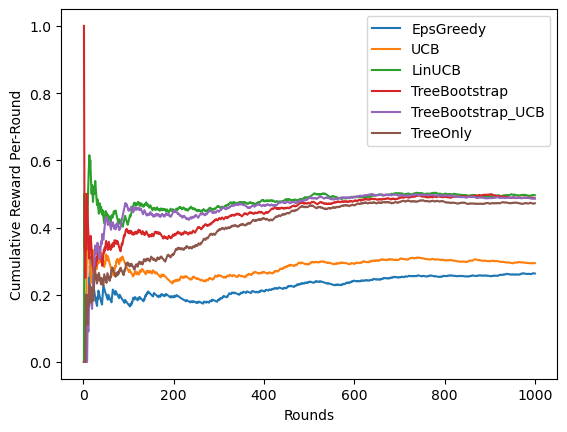

In [63]:
# plot cumulative reward per round
eg_results, ucb_results, linucb_results, tbs_results, tbucb_results, only_results, round_list = [], [], [], [], [], [], [] # create lists
n_rounds = 1000                            # the total number of rounds
eg_sum, ucb_sum,linucb_sum, tbs_sum, tbucb_sum, only_sum = 0, 0, 0, 0, 0, 0 # set the initial reward sum

# nラウンドまでの累積報酬 / ラウンド数n = 平均報酬
# get the 800 results from the previous run per each algorithm
for n_round in range(1, n_rounds + 1):              # start from 1 to avoid zero devision error
    eg_sum += results_EpsGreedy[n_round-1]
    ucb_sum += results_UCB[n_round-1]
    linucb_sum += results_LinUCB[n_round-1]
    tbs_sum += results_TreeBootstrap[n_round-1]
    tbucb_sum += results_TreeBootstrap_UCB[n_round-1]
    only_sum += results_TreeBootstrap_Only[n_round-1]
    eg_results.append(eg_sum/n_round)
    ucb_results.append(ucb_sum/n_round)
    linucb_results.append(linucb_sum/n_round)
    tbs_results.append(tbs_sum/n_round)
    tbucb_results.append(tbucb_sum/n_round)
    only_results.append(only_sum/n_round)
    round_list.append(n_round)

# plot the results
plt.plot(round_list,eg_results, label = "EpsGreedy")
plt.plot(round_list,ucb_results, label = "UCB")
plt.plot(round_list,linucb_results, label = "LinUCB")
plt.plot(round_list,tbs_results, label = "TreeBootstrap")
plt.plot(round_list, tbucb_results, label = "TreeBootstrap_UCB")
plt.plot(round_list, only_results, label = "TreeOnly")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()


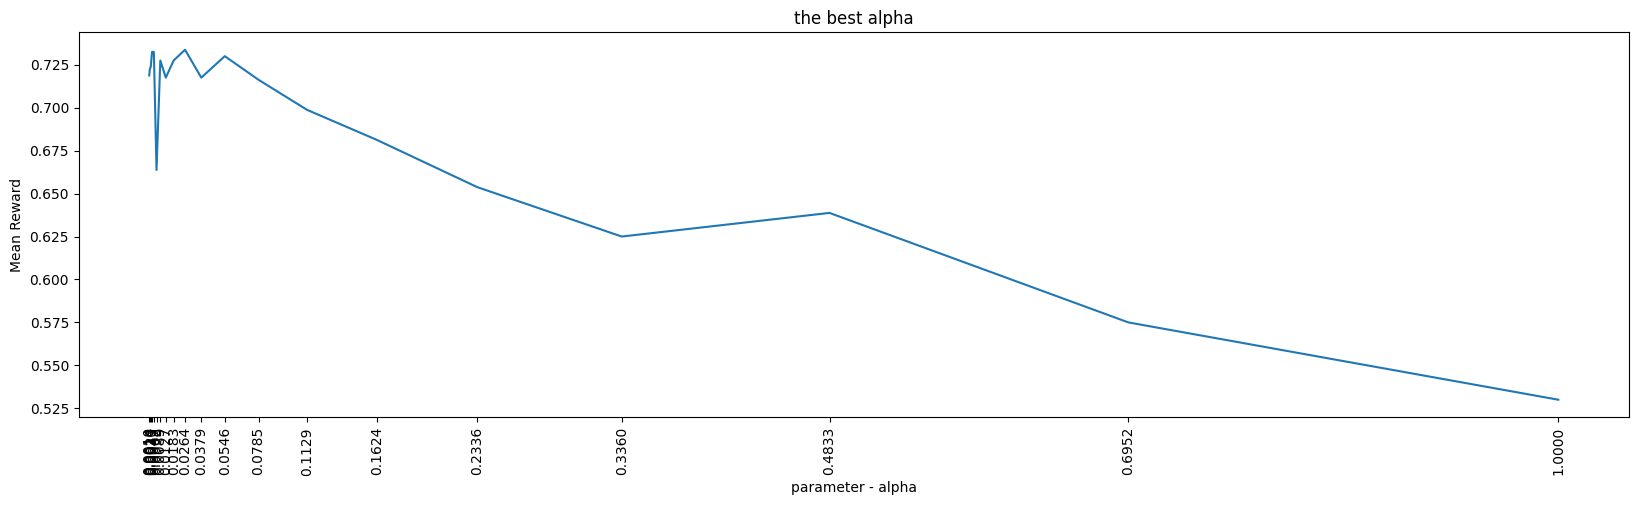

The best alpha for LinUCB is 0.026 with reward 0.73375


In [29]:
# hyperparameter optimization
alpha_list = np.logspace(-3,0,num= 20)    # generate valid alpha values
n_rounds = 800                            # set the initial number of round
max_reward = -np.inf                      # set the initial max reward
best_alpha = None                         # set the initial best alpha
results = []

# run with a set of alpha
for alpha in alpha_list:
    grid_mab = LinUCB(10, 10, alpha)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    results.append(temp_result)
    if temp_result > max_reward:  # get the maximum mean rewards with the best alpha
        best_alpha = alpha
        max_reward = temp_result


# show the plot
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(alpha_list,results)
plt.xticks(alpha_list, rotation = 'vertical')
plt.title('the best alpha')
plt.ylabel('Mean Reward')
plt.xlabel('parameter - alpha')
plt.show()
print("The best alpha for LinUCB is", round(best_alpha, 3), "with reward", max_reward)

#The best alpha for LinUCB is 0.026 with reward 0.73375


## 6. Implement KernelUCB contextual MAB

In [30]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.

    eta : float
        Positive real explore-exploit parameter.

    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        if not (type(gamma) == float  or gamma.dtype == 'float64'):
            raise TypeError("`gamma` must be float type")
        if not np.isreal(gamma):
            raise ValueError("`gamma` must be a real number")
        if not (type(eta) == float  or eta.dtype == 'float64'):
            raise TypeError("`eta` must be float type")
        if not np.isreal(eta):
            raise ValueError("`eta` must be a real number")

        self.n_dims = n_dims                # the number of dimension
        self.gamma = gamma                  # regularization parameter
        self.eta  = eta                     # exploration parameter
        self.kern = kern                    # kernel function
        self.inv_K = None                   # inversed kernel matrices
        self.u = np.zeros(self.n_arms)      # upper bounds of probability
        self.y = np.empty(0)                # reward history
        self.pre_x = np.empty(0)            # collect the previous contexts(x) for b
        self.n_round = 0                    # count the number of round

    # return the arm with the highest upper bounds of rewards
    def play(self, context):
        super().play(context)
        if self.n_round == 0:               # set the initial upper bound reward
            self.u[0] = 1.0
        else:
            k = self.kern(context, self.pre_x)         # calculate all kernel fn for previous contexts
            for arm in range(self.n_arms):
                shaped_context = context[arm].reshape(1, -1)
                sigma = np.sqrt(self.kern(shaped_context, shaped_context) - k[arm] @ self.inv_K  @ k[arm])   # calculate width (sigma)
                self.u[arm] = k[arm] @ self.inv_K @ self.y + (self.eta / np.sqrt(self.gamma)) * sigma        # calculate upper bound

        arm = break_tie(self.u)
        return arm

    def update(self, arm, reward, context):
        shaped_context = context[arm].reshape(1, -1)            # reshape context
        shaped_reward = np.array(reward).reshape(1, -1)         # reshape reward

        if self.n_round == 0:                                   # set the first values
            self.y = shaped_reward
            self.pre_x = shaped_context
            self.K = self.kern(shaped_context, shaped_context) + self.gamma
            self.inv_K  = 1 / (self.K)

        else:
            self.y = np.r_[self.y, shaped_reward]               # update reward
            k = self.kern(context, self.pre_x)                  # calculate k (xa,t)
            b = k[arm].reshape(self.n_round, 1)

            bT_invK = b.T @ self.inv_K                          # previously calculate expensive calculation
            invK_b = self.inv_K  @ b
            K22 = np.linalg.inv(self.kern(shaped_context, shaped_context) + self.gamma - bT_invK @ b)
            K11 = self.inv_K + K22 * invK_b @ bT_invK
            K12 = - K22 * invK_b
            K21 = - K22 * bT_invK

            self.pre_x = np.r_[self.pre_x, shaped_context]      # update previous context
            self.inv_K = np.vstack((np.hstack((K11, K12)), np.hstack((K21, K22))))    # update inverse K value

        self.n_round += 1



In [31]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))


KernelUCB average reward 0.73625


In [32]:
# hyperparameter optimization
gamma_list = np.linspace(0, 1, num = 11)[1:]       # generate valid gamma values & remove 0.0
eta_list = np.linspace(0, 0.5, num = 11)[1:]       # generate valid eta values & remove 0.0
n_rounds = 800                                     # set the initial number of round
gam_max_reward, eta_max_reward = -np.inf, -np.inf  # set the initial max reward for gamma and eta

# get the maximum mean rewards with the the initial eta
eta = 0.1
for gam in gamma_list:
    grid_mab = KernelUCB(10, 10, gam, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > gam_max_reward:      # get the maximum mean rewards with the best eta and gamma
        gam_max_reward = temp_result
        best_gamma = gam

print("The best gamma for Kernel UCB is {", round(best_gamma, 3), "} with reward", gam_max_reward)

for eta in eta_list:
    grid_mab = KernelUCB(10, 10, best_gamma, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > eta_max_reward:   # get the maximum mean rewards with the best gamma
        eta_max_reward = temp_result
        best_eta =  eta

print("The best eta for Kernel UCB is {", round(best_eta, 3), "} with reward", eta_max_reward)


The best gamma for Kernel UCB is { 0.1 } with reward 0.79375
The best eta for Kernel UCB is { 0.15 } with reward 0.7375


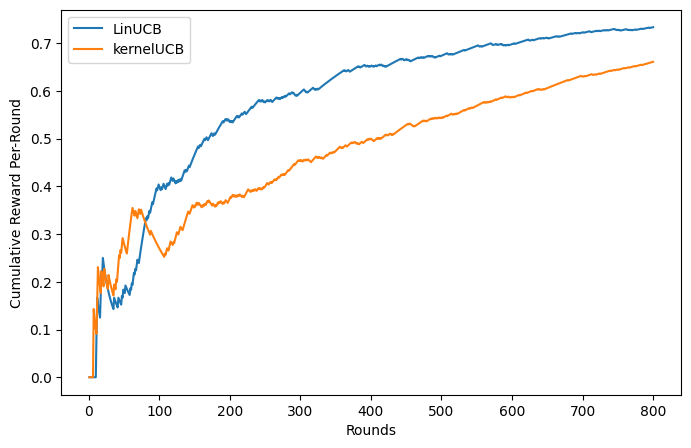

In [33]:
# your plotting code here LinUCB vs Kernel UCB
best_lin_results, best_ker_results, round_list = [], [], []        # create lists for results
n_rounds = 800                                                     # the total number of rounds
best_lin_sum, best_ker_sum = 0, 0                                  # set the initial reward sum

best_lin_mab = LinUCB(10, 10, best_alpha)
best_results_LinUCB = offlineEvaluate(best_lin_mab, arms, rewards, contexts,800)

# run UCB algorithms
best_kernel_mab = KernelUCB(10, 10, best_gamma, best_eta , rbf_kernel)
best_results_KernelUCB = offlineEvaluate(best_kernel_mab, arms, rewards, contexts, 800)

for n_round in range(1, n_rounds + 1):
    best_lin_sum += best_results_LinUCB[n_round-1]
    best_ker_sum += best_results_KernelUCB[n_round-1]

    # append ccumulative rewards
    best_lin_results.append(best_lin_sum/n_round)
    best_ker_results.append(best_ker_sum/n_round)
    round_list.append(n_round)

# plot
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(round_list, best_lin_results, label = "LinUCB")
plt.plot(round_list, best_ker_results, label = "kernelUCB")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()
